In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner # 自作モジュール

In [2]:
names = [
    "race_id",
    "year",
    "month",
    "day",
    "times",
    "place",
    "daily",
    "race_num",
    "horse",
    "jockey_id",
    "horse_N",
    "waku_num",
    "horse_num",
    "class_code",
    "track_code",
    "corner_num",
    "dist",
    "state",
    "weather",
    "age_code",
    "sex",
    "age",
    "basis_weight",
    "blinker",
    "weight",
    "inc_dec",
    "weight_code",
    "win_odds",
    "rank",
    "time_diff",
    "time",
    "corner1_rank",
    "corner2_rank",
    "corner3_rank",
    "corner4_rank",
    "last_3F_time",
    "last_3F_rank",
    "Ave_3F",
    "PCI",
    "last_3F_time_diff",
    "leg",
    "pop",
    "prize",
    "error_code",
    "father",
    "mother",
    "id"
]

In [3]:
df2023 = pd.read_csv("../Data/record_data_2023.csv", encoding="shift-jis", header=None, names=names)
df2022 = pd.read_csv("../Data/record_data_2022.csv", encoding="shift-jis", header=None, names=names)
df = pd.concat([df2023, df2022])
df.tail()

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,...,Ave_3F,PCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,id
47215,202209041004081211,22,9,4,4,小倉,8,12,ワンダークローバー,1138,...,37.05,50.7,1.5,後方,9.0,0,0,ゴールドシップ,シーギリアレディー,2018103127
47216,202209041004081212,22,9,4,4,小倉,8,12,ピーニャ,1141,...,36.90,49.2,1.0,中団,12.0,0,0,キングカメハメハ,ムードインディゴ,2018105295
47217,202209041004081213,22,9,4,4,小倉,8,12,ホウオウフウジン,1163,...,37.05,43.8,1.5,後方,5.0,0,0,ロードカナロア,アゲヒバリ,2019105032
47218,202209041004081214,22,9,4,4,小倉,8,12,カルトゥーシュ,1193,...,36.78,50.8,0.6,差し,4.0,120,0,トーセンラー,バシマー,2019100579
47219,202209041004081215,22,9,4,4,小倉,8,12,シホノスペランツァ,1126,...,36.84,53.5,0.8,先行,2.0,770,0,ブラックタイド,メジロスプレンダー,2019105654


In [4]:
df2023.shape

(47672, 47)

In [5]:
df2 = my_modules.common_process(df)
df2.head()

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy["place_num"] = df_copy["place"].replace(place_dict).astype(int)


,year,month,day,times,place,daily,race_num,horse,jockey_id,horse_N,...,mother,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,datetime,target,target3
19419,2022,1,5,1,中山,1,1,ミュージアムピース,1109,16,...,コウギョウマシェリ,2019104143,2022010506010101,ダート,平地,R,中山ダート1200,2022-01-05 01:02:00,0,0
19423,2022,1,5,1,中山,1,1,ブラッドライン,5212,16,...,フルオブスターズ,2019101003,2022010506010101,ダート,平地,R,中山ダート1200,2022-01-05 01:02:00,0,0
19422,2022,1,5,1,中山,1,1,ニシノアナ,1192,16,...,レッドセイリング,2019103610,2022010506010101,ダート,平地,R,中山ダート1200,2022-01-05 01:02:00,1,1
19421,2022,1,5,1,中山,1,1,ヤマタケコーチャン,1117,16,...,エコーズインザウインド,2019102153,2022010506010101,ダート,平地,R,中山ダート1200,2022-01-05 01:02:00,0,0
19420,2022,1,5,1,中山,1,1,アイスケイブ,1122,16,...,アイスパステル,2019105024,2022010506010101,ダート,平地,R,中山ダート1200,2022-01-05 01:02:00,0,0


In [6]:
def feature_engineering(df_to_copy, feature_col_to_copy=None):
    if feature_col_to_copy == None :
        feature_col_to_copy = ["waku_num", "horse_num", "sex", "age", "basis_weight", "blinker", "weight", "inc_dec"]
    feature_col = feature_col_to_copy.copy()
    df = df_to_copy.copy()

    # 直近3レースの結果とその平均, 過去全てのレースの記録の平均を追加
    last_race_col = ["weight", "inc_dec", "last_3F_time", "Ave_3F", "PCI"]
    for col in last_race_col:
        grouped = df.groupby("horse", observed=True)[col]
        for i in range(1, 4):
            #　過去1-3レースの結果を追加
            colname = f"{col}_last_{i}"
            df[colname] = grouped.shift(1)
            feature_col.append(colname)
        
        # 過去3レース分の結果の平均を追加
        df[f"{col}_mean_last_1_to_3"] = df[[f"{col}_last_{i}" for i in range(1, 4)]].mean(axis=1, skipna=True)
        feature_col.append(f"{col}_mean_last_1_to_3")

        # 過去全レース文の特徴量を追加
        cumsum = grouped.cumsum()
        count = grouped.cumcount()
        df[f"{col}_mean_all"] = (cumsum - df[col]) / count.replace(0, np.nan)
        feature_col.append(f"{col}_mean_all")


    # 過去その馬の全てのレースの1着率
    grouped = df.groupby("horse", observed=True)["target"]
    count = grouped.cumcount()
    cumsum = grouped.cumsum()
    df["win_rate"] = (cumsum-df["target"]) / count.replace(0, np.nan)

    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["track_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["field_type"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["turn_type"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["weather"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["state"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["place"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["corner_num"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["class_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["basis_weight"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["age_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["weight_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["weather", "state"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist", "corner_num"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist", "track_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist", "class_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["place", "field_type", "dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["place", "field_type", "dist", "class_code"])


    # その他特徴量を追加
    # weightは300kg以下の馬がいないことからこのようにした。
    df["basis_weight_per_weight"] = df["basis_weight"] / df["weight"].clip(lower=300) * 100 # 斤量/馬体重（％）
    feature_col.append("basis_weight_per_weight")
    df["basis_weight_plus_weight"] = df["basis_weight"] + df["weight"] # 斤量＋馬体重
    feature_col.append("basis_weight_plus_weight")
    df["inc_dec_rate"] = df["inc_dec"] / df["weight"].clip(lower=300) * 100 # 増減/馬体重（％）
    feature_col.append("inc_dec_rate")
    
    # 前回と同じfield_typeかどうか
    df["last_field_type"] = df.groupby(["horse"], observed=True)["field_type"].shift(1)
    df["same_field_type"] =  df["field_type"] == df["last_field_type"]
    df["same_field_type"] = df["same_field_type"].astype("object")
    df = df.drop(["last_field_type"], axis=1)
    feature_col.append("same_field_type")

    # 前回と同じクラスか
    df["last_class_code"] = df.groupby(["horse"], observed=True)["class_code"].shift(1)
    df["same_class_code"] = df["class_code"] == df["last_class_code"]
    df["same_class_code"] = df["same_class_code"].astype("object")
    df = df.drop(["last_class_code"], axis=1)
    feature_col.append("same_class_code")

    # 中何日か
    df["last_race_date"] = df.groupby("horse", observed=True)["datetime"].shift(1)
    df["interval"] = df["datetime"] - df["last_race_date"]
    df["interval"] = df["interval"].dt.days
    df = df.drop(["last_race_date"], axis=1)
    feature_col.append("interval")

    print(feature_col)
    display(df.tail())

    return df, feature_col


# グループ化したtarget-encodingをする関数
def grouped_horse_winning_rate(df, feature_col_to_copy, cols=None):
    feature_col = feature_col_to_copy.copy()

    if cols == None :
        print("Error: please select cols")
        return
    
    # 1着の確率で計算
    grouped = df.groupby(["horse", *cols], observed=True)["target"]
    cumsum = grouped.cumsum()
    count = grouped.cumcount()
    feature_name = "win_rate_" + "_".join(cols)
    df[feature_name] = (cumsum-df["target"]) / count.replace(0, np.nan)

    feature_col.append(feature_name)

    # 1-3着の確率で計算
    grouped = df.groupby(["horse", *cols], observed=True)["target3"]
    cumsum = grouped.cumsum()
    count = grouped.cumcount()
    feature_name = "win_rate3_" + "_".join(cols)
    df[feature_name] = (cumsum-df["target3"]) / count.replace(0, np.nan)

    feature_col.append(feature_name)

    return df, feature_col


In [7]:
df3, feature_col = feature_engineering(df2)
df3 = df3[df3.year == 2023]
df3.head()

['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'blinker', 'weight', 'inc_dec', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'PCI_last_1', 'PCI_last_2', 'PCI_last_3', 'PCI_mean_last_1_to_3', 'PCI_mean_all', 'win_rate_dist', 'win_rate3_dist', 'win_rate_track_code', 'win_rate3_track_code', 'win_rate_field_type', 'win_rate3_field_type', 'win_rate_turn_type', 'win_rate3_turn_type', 'win_rate_weather', 'win_rate3_weather', 'win_rate_state', 'win_rate3_state', 'win_rate_place', 'win_rate3_place', 'win_rate_corner_num', 'win_rate3_corner_num', 'win_rate_class_code', 'win_rate3_class_code', 'win_rate_basis_weight',

,year,month,day,times,place,daily,race_num,horse,jockey_id,horse_N,...,win_rate_place_field_type_dist,win_rate3_place_field_type_dist,win_rate_place_field_type_dist_class_code,win_rate3_place_field_type_dist_class_code,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,same_field_type,same_class_code,interval
43875,2023,12,28,5,阪神,9,12,テイエムイダテン,1144,16,...,0.0,0.00,0.0,0.0,11.836735,548.0,2.857143,True,True,201.0
43870,2023,12,28,5,阪神,9,12,メイショウドウドウ,1171,16,...,0.0,0.25,0.0,0.0,11.646586,556.0,0.803213,True,True,32.0
43873,2023,12,28,5,阪神,9,12,スーサンアッシャー,660,16,...,NaN,NaN,NaN,NaN,12.184874,534.0,0.420168,True,True,32.0
43871,2023,12,28,5,阪神,9,12,オルダージュ,732,16,...,NaN,NaN,NaN,NaN,12.083333,538.0,-2.083333,True,True,347.0
43874,2023,12,28,5,阪神,9,12,アネゴハダ,1186,16,...,0.0,0.00,0.0,0.0,11.864407,528.0,1.694915,True,True,26.0


,year,month,day,times,place,daily,race_num,horse,jockey_id,horse_N,...,win_rate_place_field_type_dist,win_rate3_place_field_type_dist,win_rate_place_field_type_dist_class_code,win_rate3_place_field_type_dist_class_code,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,same_field_type,same_class_code,interval
19441,2023,1,5,1,中山,1,1,レディアス,1092,16,...,NaN,NaN,NaN,NaN,12.616822,482.0,1.401869,False,False,80.0
19443,2023,1,5,1,中山,1,1,シティオブヨーク,1162,16,...,NaN,NaN,NaN,NaN,12.068966,520.0,2.586207,False,False,59.0
19456,2023,1,5,1,中山,1,1,ニシノスイセイ,1158,16,...,NaN,NaN,NaN,NaN,11.965812,524.0,1.282051,False,True,74.0
19455,2023,1,5,1,中山,1,1,ハローマイラブリー,1122,16,...,NaN,NaN,NaN,NaN,10.074627,590.0,0.000000,False,True,17.0
19454,2023,1,5,1,中山,1,1,シュバルツガイスト,666,16,...,0.0,1.0,0.0,1.0,11.522634,542.0,-0.823045,True,True,19.0


[I 2025-06-03 23:37:32,219] A new study created in memory with name: no-name-82042334-b527-46d1-ab2c-98db0462b1ce
[I 2025-06-03 23:37:32,857] Trial 0 finished with value: 0.24156852058719933 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.3248149123539492, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.7579479953348001, 'path_smooth': 8.324426408004218}. Best is trial 0 with value: 0.24156852058719933.
[I 2025-06-03 23:37:35,601] Trial 1 finished with value: 0.2317255620072978 and parameters: {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lambda

Best params :  {'max_bin': 204, 'num_leaves': 90, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 9.852352436716298, 'bagging_fraction': 0.47487526501202765, 'bagging_freq': 1, 'feature_fraction': 0.5278567569011299, 'lambda_l1': 1.0079475141988386e-08, 'lambda_l2': 3.458259327175713e-08, 'min_gain_to_split': 4.432119849996217, 'max_depth': 3, 'learning_rate': 0.01203792189110358, 'path_smooth': 3.20857405998796}
Sum of predict      is : 6
Sum of predict rate is : 0.0004415661


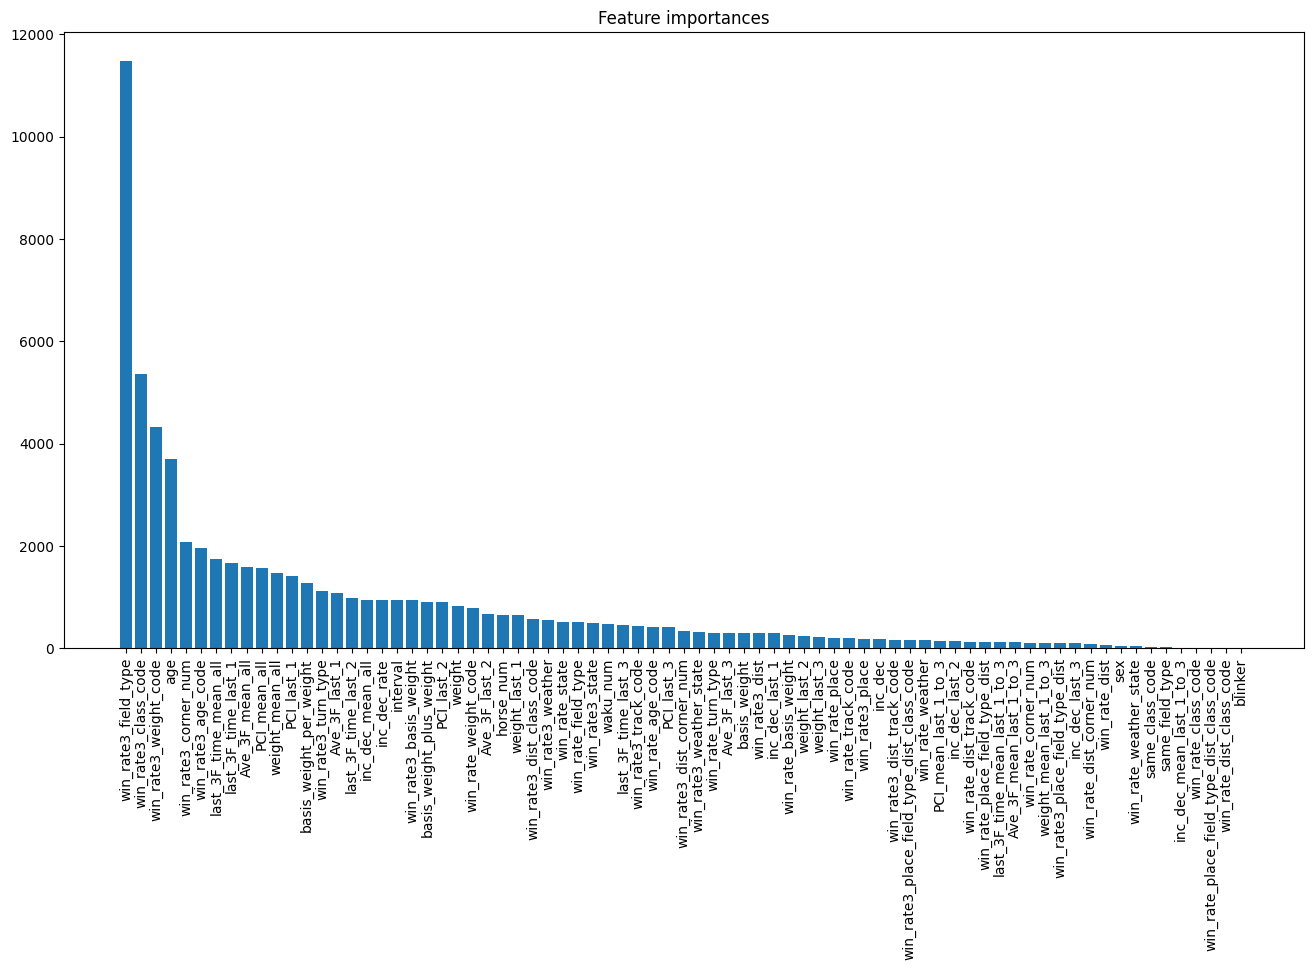

In [ ]:
memo = "add last race score, last race winning_rate. n_rials=300."
model = model_tuner.simple_lightGBM(df3, feature_col, memo=memo, n_trials=300, save_result=False, visualization=True)